## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/HW1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1LXjrpy4Q_n72wJfqipS5oiQcJ9ee9ReW/AN2DL/HW1


## ⚙️ Import Libraries

In [ ]:
!pip install keras_cv

In [ ]:
import random
import keras_cv
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.models import Model
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications import EfficientNetB3, MobileNetV2, ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

np.random.seed(44)
tf.random.set_seed(44)
seed = 44

## ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz')
X_raw = data['images']
y_raw = data['labels']

## Remove Outliers

In [ ]:
shrek = X_raw[13458]
mj = X_raw[13700]
matching_indices = [i for i in range(len(X_raw)) if ((np.array_equal(X_raw[i], shrek)) or ((np.array_equal(X_raw[i], mj)))) ]

X = np.delete(X_raw, matching_indices, axis=0)
y = np.delete(y_raw, matching_indices, axis=0)

In [ ]:
print(f'Original array shape: {X_raw.shape}')
print(f'Filtered array shape: {X.shape}')

Original array shape: (13759, 96, 96, 3)
Filtered array shape: (11959, 96, 96, 3)


## Visualize Data

In [ ]:
def summarize_array(array):
    summary = {
        'shape': array.shape,
        'dtype': array.dtype,
        'size': array.size,
        'min': array.min(),
        'max': array.max(),
        'mean': array.mean(),
        'std': array.std(),
        'median': np.median(array),
        'percentiles': np.percentile(array, [25, 50, 75])
    }
    return summary

summarize_array(X)

{'shape': (11959, 96, 96, 3),
 'dtype': dtype('uint8'),
 'size': 330642432,
 'min': 0,
 'max': 255,
 'mean': 182.84433917725357,
 'std': 54.6544808559125,
 'median': 195.0,
 'percentiles': array([158., 195., 226.])}

In [ ]:
summarize_array(y)

{'shape': (11959, 1),
 'dtype': dtype('uint8'),
 'size': 11959,
 'min': 0,
 'max': 7,
 'mean': 3.7018981520193996,
 'std': 2.3072807268586946,
 'median': 3.0,
 'percentiles': array([1., 3., 6.])}

In [ ]:
unique_values, counts = np.unique(y, return_counts=True)

value_counts = dict(zip(unique_values, counts))
value_counts

{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}

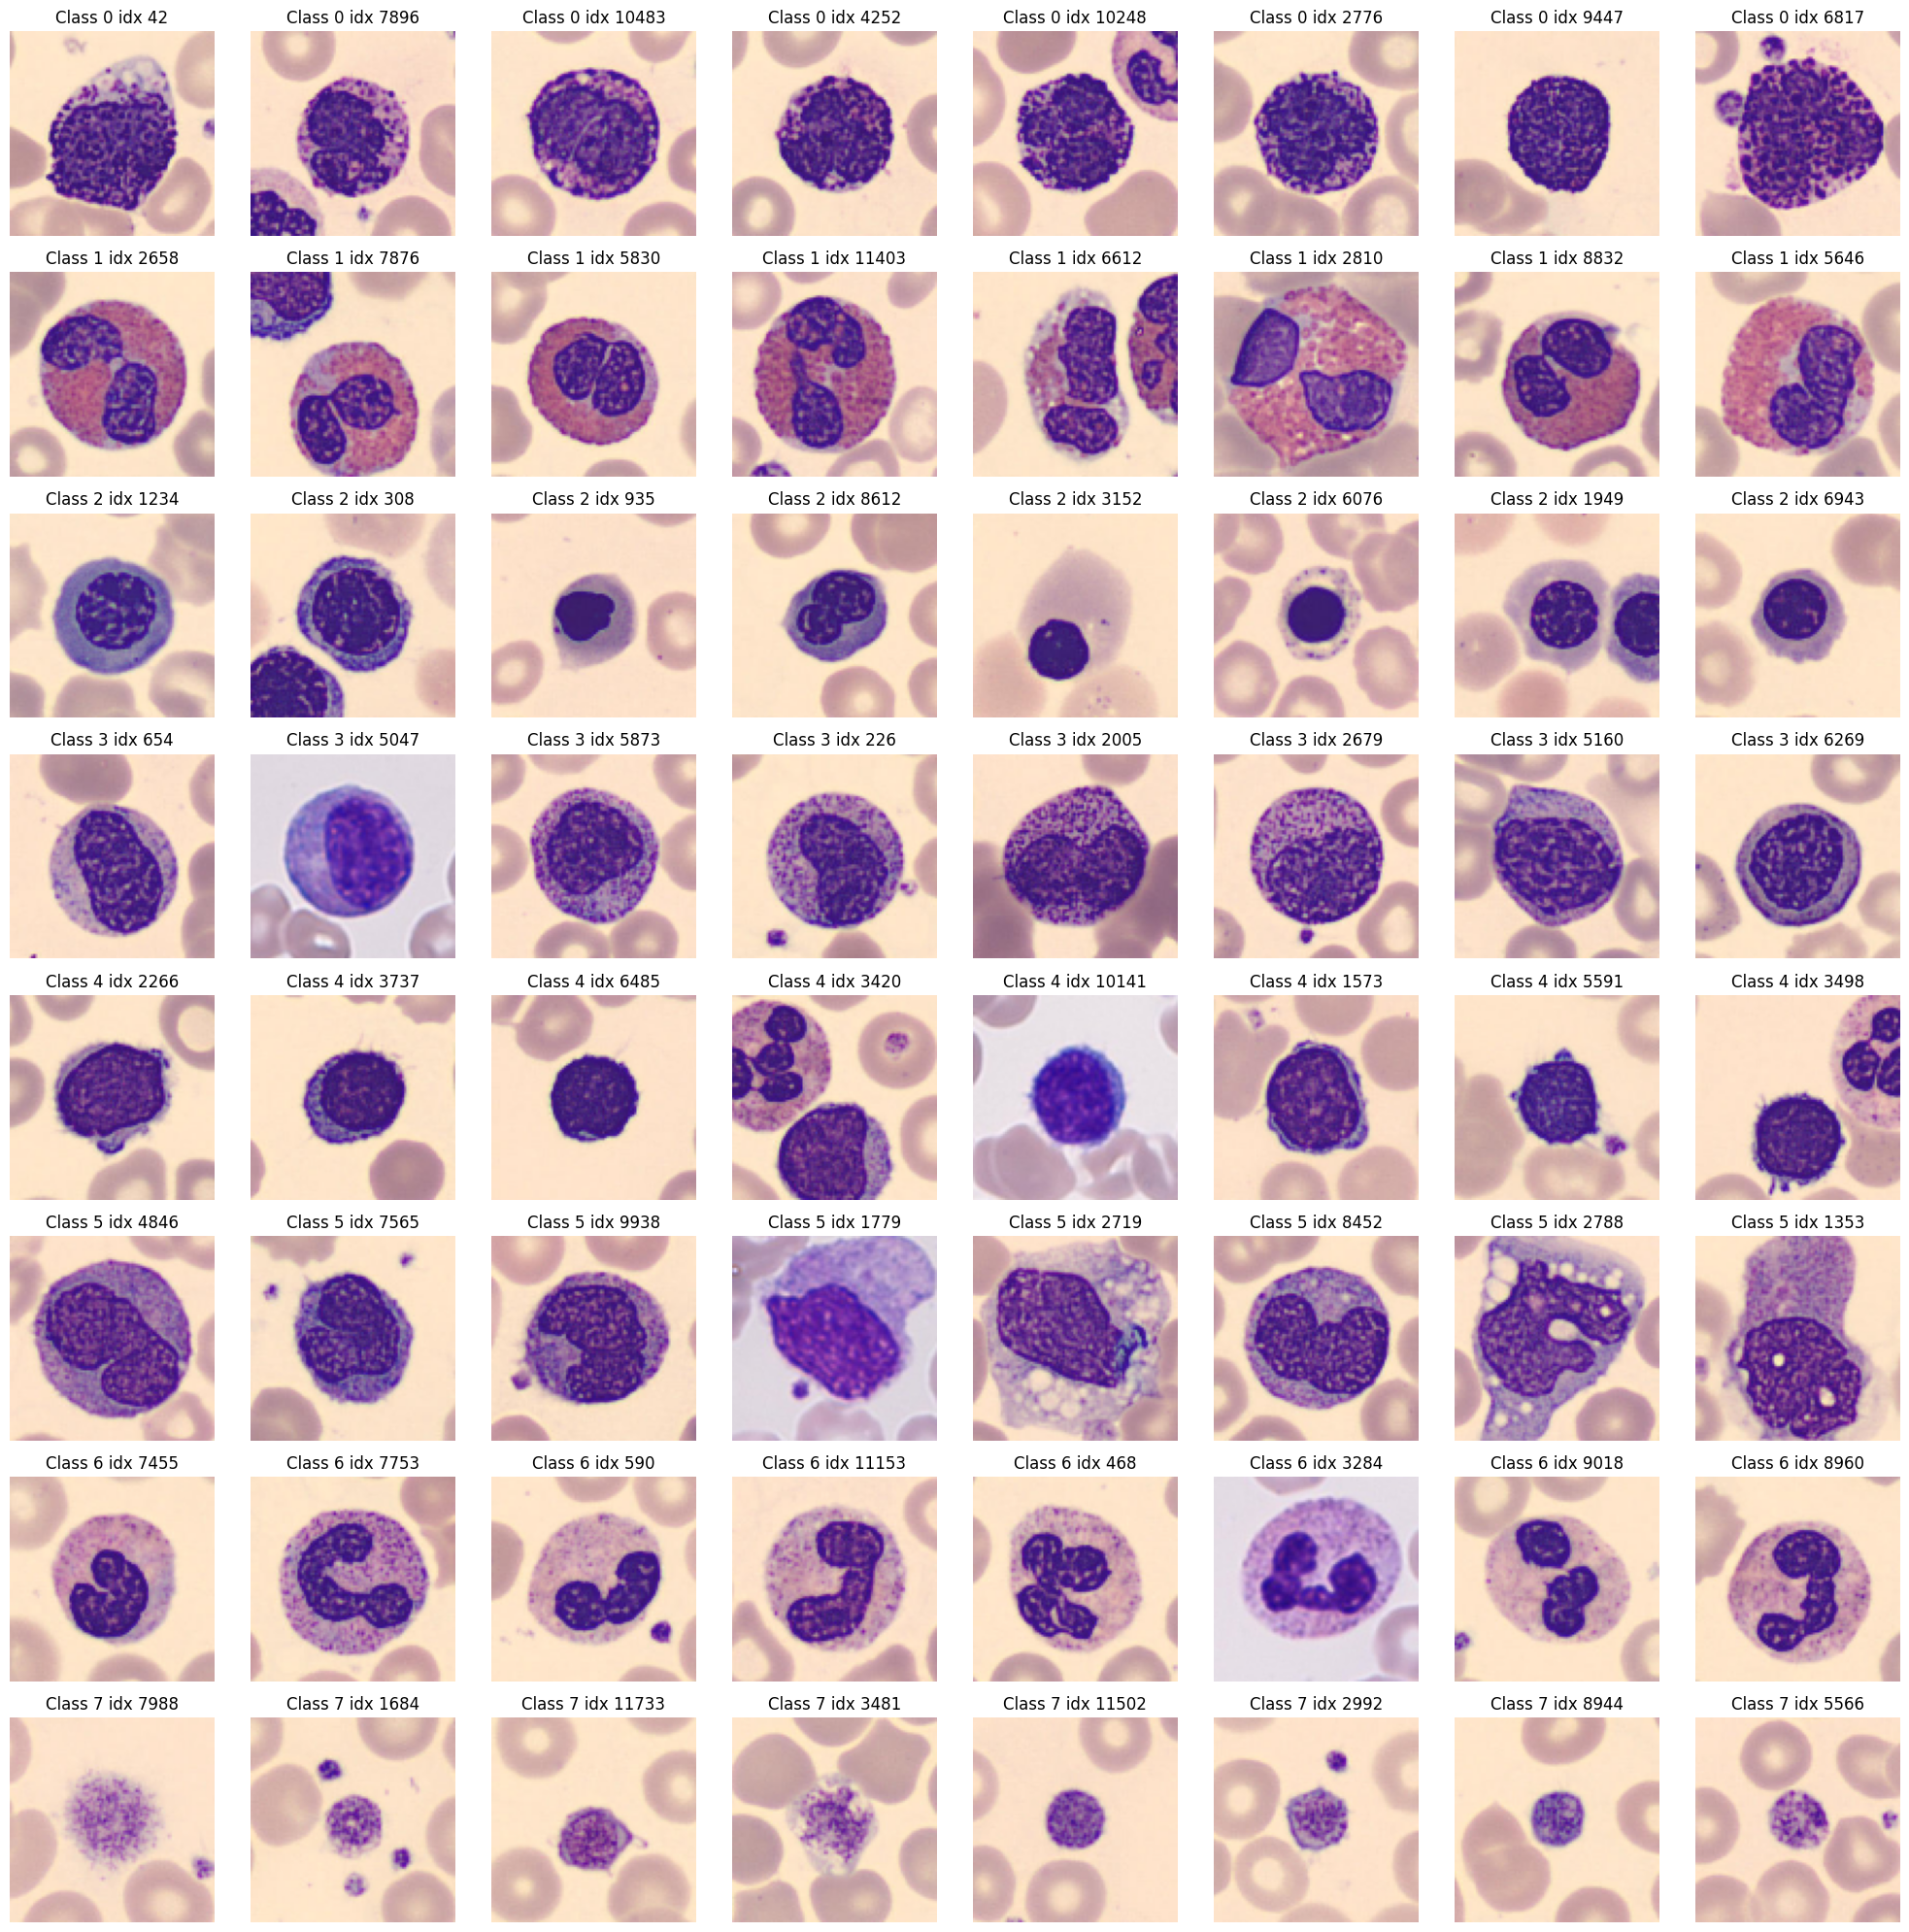

In [ ]:
num_classes = 8
num_img_per_class = 8

fig, axes = plt.subplots(num_classes, num_img_per_class, figsize=(20, 20))

for class_label in range(num_classes):
    indices = [i for i, label in enumerate(y) if label == class_label]

    random_indices = random.sample(indices, num_img_per_class)

    for i, idx in enumerate(random_indices):
        ax = axes[class_label, i]
        ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
        ax.set_title(f'Class {class_label} idx {idx}')
        ax.axis('off')

plt.tight_layout()
plt.show()

## 🛠️ Train and Save the Model

### Convert Data Type

In [ ]:
float_X = X.astype('float32')

one_hot_y = tfk.utils.to_categorical(y).astype('float32')

### Creat train, validation, and test sets

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(float_X, one_hot_y, random_state=seed, test_size=0.20, stratify=np.argmax(y,axis=1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

### Sample Weight

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Assuming y_train contains the integer class labels
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))
def compute_sample_weight(labels, class_weights):
    sample_weights = np.sum(labels * np.array(list(class_weights.values())), axis=1)
    return sample_weights
sample_weights = compute_sample_weight(y_train, class_weights_dict)

### Augmentations

In [ ]:
augmix_layer = keras_cv.layers.AugMix(value_range=(0, 255), severity=0.5, alpha=0.5)
randaugment_layer = keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.5)
cutmix_layer = keras_cv.layers.CutMix(alpha=1.0)
mixup_layer = keras_cv.layers.MixUp(alpha=0.2)
channel_shuffle_layer = keras_cv.layers.ChannelShuffle(groups=3)
random_color_degeneration_layer = keras_cv.layers.RandomColorDegeneration(factor=0.4)

def apply_augmix(images, labels):
    return augmix_layer(images), labels

def apply_randaugment(images, labels):
    return randaugment_layer(images), labels

def apply_cutmix(images, labels):
    augmented = cutmix_layer({"images": images, "labels": labels})
    return augmented["images"], augmented["labels"]

def apply_mixup(images, labels):
    augmented = mixup_layer({"images": images, "labels": labels})
    return augmented["images"], augmented["labels"]

def apply_channel_shuffle(images, labels):
    return channel_shuffle_layer(images), labels

def apply_random_color_degeneration(images, labels):
    return random_color_degeneration_layer(images), labels

def apply_combined_augmentations(images, labels):
    rand_choice = tf.random.uniform(shape=[], minval=0, maxval=6, dtype=tf.int32)

    if rand_choice == 0:
        return apply_augmix(images, labels)
    elif rand_choice == 1:
        return apply_randaugment(images, labels)
    elif rand_choice == 2:
        return apply_cutmix(images, labels)
    elif rand_choice == 3:
        return apply_mixup(images, labels)
    elif rand_choice == 4:
        return apply_channel_shuffle(images, labels)
    else:
        return apply_random_color_degeneration(images, labels)

def map_fn(x, y, w):
    x_augmented, y_augmented = apply_combined_augmentations(x, y)
    return x_augmented, y_augmented, w

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1024)
    .batch(batch_size)
    .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
class AddGaussianNoise(tfkl.Layer):
    def __init__(self, mean=0.0, stddev=0.05, **kwargs):
        super().__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
            return inputs + noise
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "mean": self.mean,
            "stddev": self.stddev
        })
        return config

class AdjustHue(tfkl.Layer):
    def __init__(self, delta=0.02, **kwargs):
        super().__init__(**kwargs)
        self.delta = delta

    def call(self, inputs, training=None):
        if training:
            return tf.image.adjust_hue(inputs, self.delta)
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "delta": self.delta
        })
        return config

class AdjustSaturation(tfkl.Layer):
    def __init__(self, minval=0.5, maxval=1.0, **kwargs):
        super().__init__(**kwargs)
        self.minval = minval
        self.maxval = maxval

    def call(self, inputs, training=None):
        if training:
            factor = tf.random.uniform(shape=[], minval=self.minval, maxval=self.maxval)
            return tf.image.adjust_saturation(inputs, factor)
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "minval": self.minval,
            "maxval": self.maxval
        })
        return config

In [ ]:
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.3),
    tfkl.RandomZoom(0.2, 0.2),
    tfkl.RandomContrast(0.5),
    tfkl.RandomCrop(80, 80),
    tfkl.Resizing(96, 96),
    AddGaussianNoise(stddev=0.05),
    AdjustHue(delta=0.02),
    AdjustSaturation(minval=0.5, maxval=1.0),
], name='Augmentation')

### Build Models

In [ ]:
input_shape = X_train.shape[1:]

output_shape = y_train.shape[1]

epochs = 100

batch_size = 32

In [ ]:
model_configs = [
    {
        'base_model_class': EfficientNetB3,
        'trainable_layers': ["block6", "block7"],
        'learning_rate': 1e-4,
        'dropout_rate': 0.5,
        'preprocess_input_func': efficientnet_preprocess_input,
        'model_name': 'EfficientNetB3'
    },
    {
        'base_model_class': MobileNetV2,
        'trainable_layers': ["block_13", "block_14", "block_15"],
        'learning_rate': 1e-4,
        'dropout_rate': 0.5,
        'preprocess_input_func': mobilenet_preprocess_input,
        'model_name': 'MobileNetV2'
    },
    {
        'base_model_class': ResNet50,
        'trainable_layers': ["conv5"],
        'learning_rate': 1e-4,
        'dropout_rate': 0.5,
        'preprocess_input_func': resnet_preprocess_input,
        'model_name': 'ResNet50'
    },
]


In [ ]:
def build_model_variant(
    base_model_class,
    input_shape,
    output_shape,
    learning_rate,
    dropout_rate,
    trainable_layers,
    augmentation,
    preprocess_input_func,
    model_name,
    seed=42,
    l2_lambda=1e-4,
):
    tf.random.set_seed(seed)

    base_model = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze specified layers
    for layer in base_model.layers:
        if any(block_name in layer.name for block_name in trainable_layers):
            layer.trainable = True

    inputs = tfkl.Input(shape=input_shape, name='input')

    if augmentation:
        x = augmentation(inputs)
    else:
        x = inputs

    x = preprocess_input_func(x)

    x = base_model(x)

    x = tfkl.BatchNormalization(name='normalization')(x)

    x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)

    if dropout_rate > 0:
        x = tfkl.Dropout(dropout_rate, name='dropout')(x)

    x = tfkl.Dense(units=output_shape, name='dense',
                   kernel_regularizer=tfk.regularizers.l2(l2_lambda))(x)

    outputs = tfkl.Activation('softmax', name='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)

    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Lion(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
models = []

for config in model_configs:
    print(f"Builfing {config['model_name']}...")
    model = build_model_variant(
        base_model_class=config['base_model_class'],
        input_shape=input_shape,
        output_shape=output_shape,
        learning_rate=config['learning_rate'],
        dropout_rate=config['dropout_rate'],
        trainable_layers=config['trainable_layers'],
        augmentation=augmentation,
        preprocess_input_func=config['preprocess_input_func'],
        model_name=config['model_name']
    )

    models.append(model)

Builfing EfficientNetB3...
Builfing MobileNetV2...
Builfing ResNet50...


In [ ]:
for model in models:
  model.summary(expand_nested=True)

Model: "EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Augmentation (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_crop (RandomCrop)        │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ resizing (Resizing)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ add_gaussian_noise              │ (None, 96, 96, 3)           │               0 │
│ (AddGaussianNoise)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ adjust_hue (AdjustHue)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ adjust_saturation               │ (None, 96, 96, 3)           │               0 │
│ (AdjustSaturation)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 3, 3, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv_pad (ZeroPadding2D)   │ (None, 97, 97, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 40)          │           1,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 40)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,801,975 (41.21 MB)

 Trainable params: 7,928,550 (30.25 MB)

 Non-trainable params: 2,873,425 (10.96 MB)

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Augmentation (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_crop (RandomCrop)        │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ resizing (Resizing)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ add_gaussian_noise              │ (None, 96, 96, 3)           │               0 │
│ (AddGaussianNoise)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ adjust_hue (AdjustHue)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ adjust_saturation               │ (None, 96, 96, 3)           │               0 │
│ (AdjustSaturation)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ Conv1 (Conv2D)                  │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ bn_Conv1 (BatchNormalization)   │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ Conv1_relu (ReLU)               │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 48, 48, 32)          │             288 │
│ (DepthwiseConv2D)                    │                             │              

 Total params: 2,273,352 (8.67 MB)

 Trainable params: 808,072 (3.08 MB)

 Non-trainable params: 1,465,280 (5.59 MB)

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Augmentation (Sequential) │ (None, 96, 96, 3)      │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_flip          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_rotation      │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_zoom          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_contrast_1    │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_crop          │ (None, 80, 80, 3)      │              0 │ -                      │
│ (RandomCrop)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ resizing (Resizing)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ add_gaussian_noise   │ (None, 96, 96, 3)      │              0 │ -                      │
│ (AddGaussianNoise)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ adjust_hue           │ (None, 96, 96, 3)      │              0 │ -                      │
│ (AdjustHue)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ adjust_saturation    │ (None, 96, 96, 3)      │              0 │ -                      │
│ (AdjustSaturation)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 96, 96)         │              0 │ Augmentation[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 96, 96)         │              0 │ Augmentation[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 96, 96)         │              0 │ Augmentation[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 96, 96, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                      

 Total params: 23,612,296 (90.07 MB)

 Trainable params: 14,996,488 (57.21 MB)

 Non-trainable params: 8,615,808 (32.87 MB)

### Train Models

In [ ]:
histories = []

for i, model in enumerate(models):
  print("Training Model")
  lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6)

  early_stopping = tfk.callbacks.EarlyStopping(
      monitor='val_accuracy',
      mode='max',
      patience=10,
      min_delta=0.00025,
      restore_best_weights=True)

  callbacks = [early_stopping, lr_scheduler]

  history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        class_weight=class_weights_dict,
        callbacks=callbacks)
  histories.append(history.history)
  model.save(f"weights{i}.keras")

Training Model
Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 85s 235ms/step - accuracy: 0.3979 - loss: 1.7935 - val_accuracy: 0.8533 - val_loss: 0.4597 - learning_rate: 1.0000e-04
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 205ms/step - accuracy: 0.7474 - loss: 0.9031 - val_accuracy: 0.7120 - val_loss: 2.2657 - learning_rate: 1.0000e-04
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.7716 - loss: 0.8166 - val_accuracy: 0.9147 - val_loss: 0.3404 - learning_rate: 1.0000e-04
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 204ms/step - accuracy: 0.7956 - loss: 0.7598 - val_accuracy: 0.9143 - val_loss: 0.2820 - learning_rate: 1.0000e-04
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 49s 203ms/step - accuracy: 0.8097 - loss: 0.7297 - val_accuracy: 0.9243 - val_loss: 0.2357 - learning_rate: 1.0000e-04
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 200ms/step - accuracy: 0.8127 - loss: 0.6946 - val_accuracy: 0.9034 - val_loss: 0.3781 - learning_rate: 1.0000e-04
Epoch 7/100
225/225 ━━━━━

### Accuracy of Models

In [ ]:
for i, history in enumerate(histories):
    val_acc = max(history['val_accuracy']) * 100
    print(f'Model {i+1} Validation Accuracy: {val_acc:.2f}%')

Model 1 Validation Accuracy: 96.78%
Model 2 Validation Accuracy: 97.66%
Model 3 Validation Accuracy: 94.40%


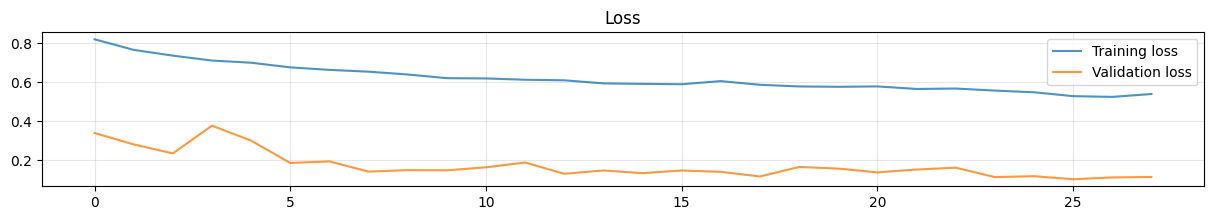

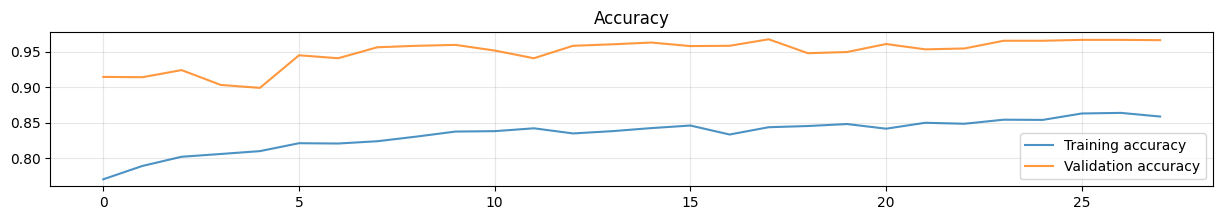

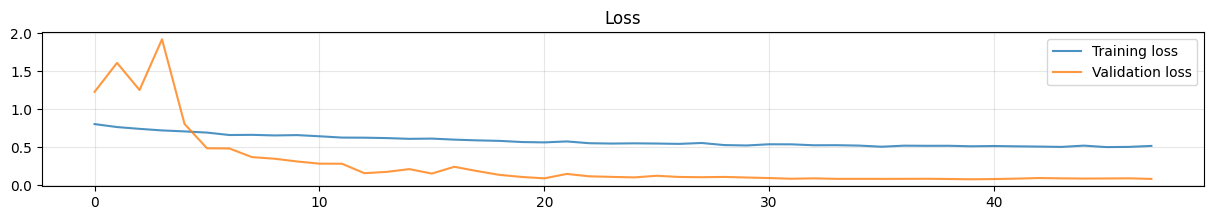

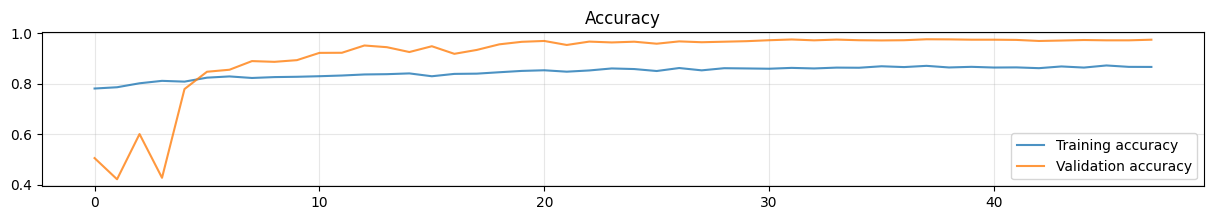

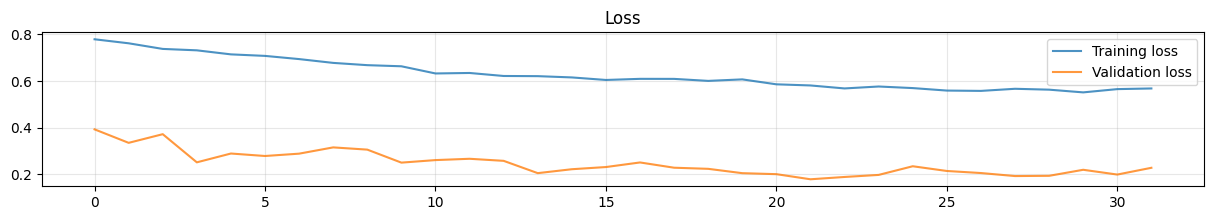

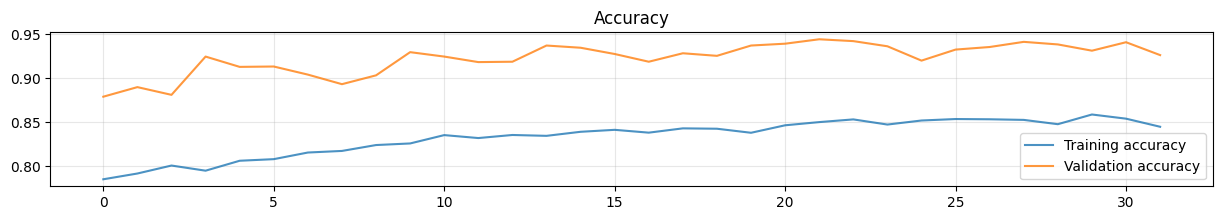

In [ ]:
for i, history in enumerate(histories):
  plt.figure(figsize=(15, 2))
  plt.plot(history['loss'][2:], label='Training loss', alpha=.8)
  plt.plot(history['val_loss'][2:], label='Validation loss', alpha=.8)
  plt.title('Loss')
  plt.legend()
  plt.grid(alpha=.3)

  plt.figure(figsize=(15, 2))
  plt.plot(history['accuracy'][2:], label='Training accuracy', alpha=.8)
  plt.plot(history['val_accuracy'][2:], label='Validation accuracy', alpha=.8)
  plt.title('Accuracy')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

### Combining Models and Plotting Final Accuracy

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Accuracy score over the test set: 0.9774
Precision score over the test set: 0.9779
Recall score over the test set: 0.9774


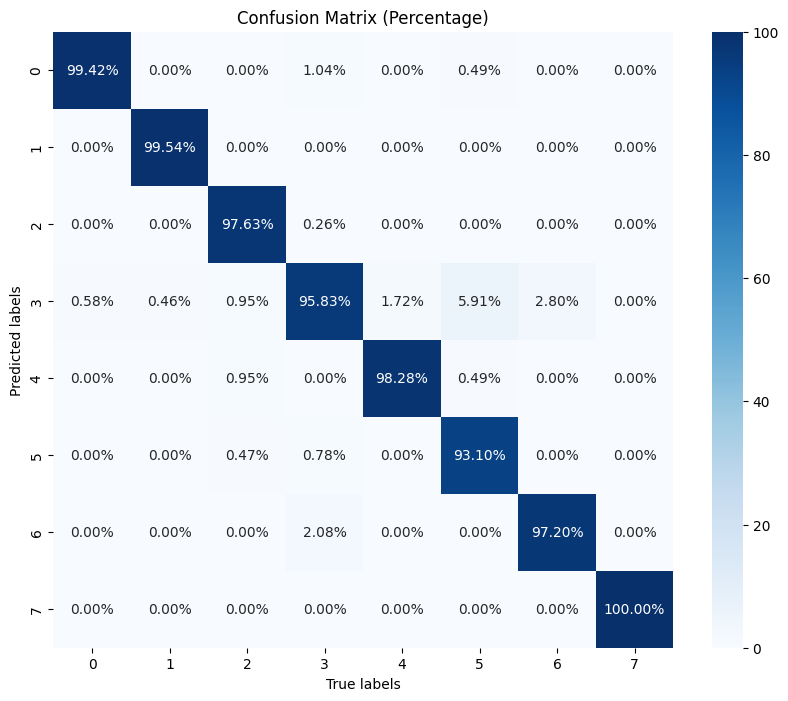

In [ ]:
test_preds = []
for model in models:
    preds = model.predict(X_test)
    test_preds.append(preds)

ensemble_test_preds = np.mean(test_preds, axis=0)

pred_classes = np.argmax(ensemble_test_preds, axis=-1)

true_classes = np.argmax(y_test, axis=-1)

accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

cm = confusion_matrix(true_classes, pred_classes)
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
annot = np.array([f"{val:.2f}%" for val in cm_percentage.flatten()]).reshape(cm.shape)

labels = range(0, 8)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage.T, annot=annot.T, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()

# Saving the Model and Files

In [ ]:
%%writefile model.py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import load_model


class AddGaussianNoise(tfkl.Layer):
    def __init__(self, mean=0.0, stddev=0.05, **kwargs):
        super().__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
            return inputs + noise
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "mean": self.mean,
            "stddev": self.stddev
        })
        return config


class AdjustHue(tfkl.Layer):
    def __init__(self, delta=0.02, **kwargs):
        super().__init__(**kwargs)
        self.delta = delta

    def call(self, inputs, training=None):
        if training:
            return tf.image.adjust_hue(inputs, self.delta)
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "delta": self.delta
        })
        return config


class AdjustSaturation(tfkl.Layer):
    def __init__(self, minval=0.5, maxval=1.0, **kwargs):
        super().__init__(**kwargs)
        self.minval = minval
        self.maxval = maxval

    def call(self, inputs, training=None):
        if training:
            factor = tf.random.uniform(shape=[], minval=self.minval, maxval=self.maxval)
            return tf.image.adjust_saturation(inputs, factor)
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "minval": self.minval,
            "maxval": self.maxval
        })
        return config


class Model:
    def __init__(self):
        self.custom_objects = {
            "AddGaussianNoise": AddGaussianNoise,
            "AdjustHue": AdjustHue,
            "AdjustSaturation": AdjustSaturation
        }
        self.model1 = load_model('weights0.keras', custom_objects=self.custom_objects)
        self.model2 = load_model('weights1.keras', custom_objects=self.custom_objects)
        self.model3 = load_model('weights2.keras', custom_objects=self.custom_objects)

    def predict(self, X):
        float_X = X.astype('float32')
        preds1 = self.model1.predict(float_X)
        preds2 = self.model2.predict(float_X)
        preds3 = self.model3.predict(float_X)
        ensemble_preds = (preds1 + preds2 + preds3) / 3.0

        final_preds = np.argmax(ensemble_preds, axis=1)
        return final_preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("K2A_%y%m%d_%H%M%S")}.zip'

!zip {filename} model.py weights0.keras weights1.keras weights2.keras

  adding: model.py (deflated 73%)
  adding: weights0.keras (deflated 8%)
  adding: weights1.keras (deflated 11%)
  adding: weights2.keras (deflated 7%)
